In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install timm

In [ ]:
!git clone https://github.com/hukenovs/hagrid.git

Для обучения модели воспользуемся моделью [HAGRID](https://github.com/hukenovs/hagrid), которая предназначена для задач определения жестов руки.

В полной версии датасета содержится 552992 FullHD изображений, разбитых на 18 классов. В нашем случае скачаем урезанную версию *--subset*, со 100 изображениями каждого из классов.

В датасете также присутствуют аннотации точек кистей рук, добытые с помощью mediapipe. Командой *--annotations* скачаем их тоже.

In [4]:
!python hagrid/download.py --save_path dataset --subset --annotations --dataset

train                          : False
test                           : False
subset                         : True
annotations                    : True
dataset                        : True
targets                        : ('call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace_inverted', 'peace', 'rock', 'stop_inverted', 'stop', 'three', 'three2', 'two_up_inverted', 'two_up')
save_path                      : dataset
--2023-06-09 14:51:21--  https://n-usr-2uzac.s3pd02.sbercloud.ru/b-usr-2uzac-mv4/hagrid/subsample.zip
Resolving n-usr-2uzac.s3pd02.sbercloud.ru (n-usr-2uzac.s3pd02.sbercloud.ru)... 37.18.122.129
Connecting to n-usr-2uzac.s3pd02.sbercloud.ru (n-usr-2uzac.s3pd02.sbercloud.ru)|37.18.122.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2520202487 (2.3G) [application/zip]
Saving to: ‘dataset/subsample/subsample.zip’

dataset/subsample/s 100%[===================>]   2.35G  10.2MB/s    in 4m 0s   

2023-06-09 14:55:23 (10.0 M

In [5]:
import json
import random
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [ ]:
!unzip /content/dataset/subsample/subsample.zip -d /content/subsample

In [ ]:
!unzip /content/dataset/subsample/ann_subsample.zip -d /content/ann_subsample

In [8]:
batch_size = 32
image_dir = Path("subsample")
annotation_dir = Path("ann_subsample", "ann_subsample")

# Подготовка датасета

Подготовим обучающую и валидационную выборки для использования в процессе обучения НС.

Так как по заданию необходимо найти только кончик указательного пальца, в Y массив сохраним координаты только его точки.

In [9]:
class KeypointsDataset(Dataset):

    def __init__(self, meta):
        self.meta = meta
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Открыли изображение
        for image_path, image_data in self.meta[idx].items():
            ...
        image = Image.open(image_dir.joinpath(image_path)).convert('RGB')
        height, width = image.height, image.width
        image = np.asarray(image)
        keypoints = []
        
        # Ищем ббокс, вырезаем изображение по ббоксу
        for bbox_data, landmark_data in zip(image_data['bboxes'], image_data['landmarks']):
            if bbox_data and landmark_data:
                
                bbox_data = np.array(bbox_data)
                bbox_data[0:3:2] = bbox_data[0:3:2] * width
                bbox_data[1:4:2] = bbox_data[1:4:2] * height
                bbox_data = np.round(bbox_data, 0).astype(int)
                
                x_min = bbox_data[0]
                x_max = bbox_data[0] + bbox_data[2]
                y_min = bbox_data[1]
                y_max = bbox_data[1] + bbox_data[3]

                image = image[y_min:y_max,x_min:x_max]

                landmark_data = np.array(landmark_data)
                landmark_data[:, 0] = landmark_data[:, 0] * width
                landmark_data[:, 1] = landmark_data[:, 1] * height
                landmark_data = landmark_data.astype(int)
                x, y = landmark_data[8]
                # for x, y in landmark_data:
                keypoints.append((x - x_min) / (x_max - x_min))
                keypoints.append((y - y_min) / (y_max - y_min))
                keypoints.append(float(1))
                break

        image = self.preprocessing(image=image)['image']
        return image, torch.Tensor(keypoints)

In [10]:
meta = []
for ann_path in annotation_dir.iterdir():
    ann = json.load(open(ann_path))
    for file_uuid, data in ann.items():
        if not data['landmarks'][0]:
            continue
        full_ann_data = {str(Path(ann_path.stem, file_uuid).with_suffix('.jpg')): data}
        meta.append(full_ann_data)
random.shuffle(meta)
val, train = meta[:int(len(meta) * 0.2)], meta[int(len(meta) * 0.2):]

In [23]:
train_dataset = KeypointsDataset(meta=train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print("Train dataset length:", len(train_dataset))

val_dataset = KeypointsDataset(meta=val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print("Val dataset length:", len(val_dataset))

Train dataset length: 1352
Val dataset length: 338


In [ ]:
for x, y in train_dataset:
    print(x.shape)
    print(y.shape)
    break

В конечном итоге имеем генератор датасетов с 1 входом и 1 выходом:
- Вход: 224x224
- Выход: 3

Количество примеров в каждой из выборок:
- Тренировочная: 1352
- Валидационная: 338

# Metrics

## Object Keypoint Similarity

In [24]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

# Создание модели

In [25]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(62720, 3),
    nn.Sigmoid()
)
model.to(device);

# Обучение

In [26]:
EPOCHS = 10
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [27]:
for epoch in range(EPOCHS):
    
    model.train()
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        
        loss = criterion(predictions, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy().reshape(-1, 3)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 3)
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :2], train_predictions[:, :2], train_targets[:, 2]))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy().reshape(-1, 3)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 3)
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets[:, :2], val_predictions[:, :2], val_targets[:, 2]))

Epoch: 0:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.028665053354966087
Train OKS: 0.9638126268296043


Epoch: 0:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9774679802103619


Epoch: 1:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.006197586888447404
Train OKS: 0.9908296248813441


Epoch: 1:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9786091368629362


Epoch: 2:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.0031973069864000346
Train OKS: 0.9952690742207146


Epoch: 2:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9800920227614008


Epoch: 3:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.0026170364878855125
Train OKS: 0.9961334549303719


Epoch: 3:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.979590185608235


Epoch: 4:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.002264887308376993
Train OKS: 0.9966630504311138


Epoch: 4:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9801717880373352


Epoch: 5:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.002081363656839659
Train OKS: 0.9969286495108878


Epoch: 5:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9799631589592245


Epoch: 6:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.00226987058128945
Train OKS: 0.9967150676154362


Epoch: 6:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9798147727374212


Epoch: 7:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.002212864165410919
Train OKS: 0.9967156636228057


Epoch: 7:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9803797556188554


Epoch: 8:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.0021034443174315575
Train OKS: 0.9969060974756457


Epoch: 8:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9805453935711972


Epoch: 9:   0%|          | 0/43 [00:00<?, ?it/s]

Training loss: 0.00213847566412242
Train OKS: 0.9969023715255549


Epoch: 9:   0%|          | 0/11 [00:00<?, ?it/s]

Val OKS: 0.9803718086665626


In [29]:
torch.save(model.state_dict(), 'model_2.pth')

# Тестирование

Так как модель обучалась на изображениях 224х224, перед предиктом предварительно необходимо обрезать по ббоксам рук.

In [52]:
img_idx = 6

for image_path, image_data in val[img_idx].items():
    image = Image.open(image_dir.joinpath(image_path)).convert('RGB')
    height, width = image.height, image.width
    image = np.asarray(image)
    keypoints = []

    # Ищем ббокс, вырезаем изображение по ббоксу
    for bbox_data, landmark_data in zip(image_data['bboxes'], image_data['landmarks']):
        if bbox_data and landmark_data:
            
            bbox_data = np.array(bbox_data)
            bbox_data[0:3:2] = bbox_data[0:3:2] * width
            bbox_data[1:4:2] = bbox_data[1:4:2] * height
            bbox_data = np.round(bbox_data, 0).astype(int)
            
            x_min = bbox_data[0]
            x_max = bbox_data[0] + bbox_data[2]
            y_min = bbox_data[1]
            y_max = bbox_data[1] + bbox_data[3]

            image = image[y_min:y_max,x_min:x_max]

            landmark_data = np.array(landmark_data)
            landmark_data[:, 0] = landmark_data[:, 0] * width
            landmark_data[:, 1] = landmark_data[:, 1] * height
            landmark_data = landmark_data.astype(int)
            for x, y in landmark_data:
                keypoints.append((x - x_min) / (x_max - x_min))
                keypoints.append((y - y_min) / (y_max - y_min))
                keypoints.append(float(1))
            break
img = train_dataset.preprocessing(image=image)['image']

In [53]:
pred = model(img.unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

50 24


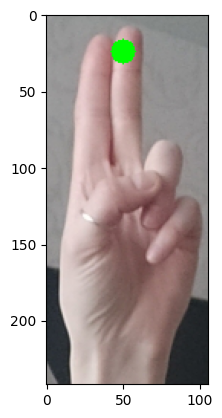

In [54]:
for i in range(0, len(pred), 3):
    if pred[i+2] > 0.75:
        x = int(pred[i] * (x_max-x_min))
        y = int(pred[i+1] * (y_max-y_min))
        print(x, y)
        cv2.circle(image, (x, y), 0, (0, 255, 0), 15)
plt.imshow(image)